### QML 2. Data Encoding Schemes and Feature Maps
This notebook present short description and syntax for various data encoding schemes, also known as feature maps. 

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries.

`qiskit, qiskit-aer, matplotlib, pylatexenc`

### 1. Basis Encoding
Suppose all features are stored in four bits like

5 → binary 0101

7 → binary 0111

0 → binary 0000

These bit strings are assigned to three sets of four qubits, so the overall 12-qubit basis state is: ∣0101 0111 0000⟩. Here, the first four qubits represent the first feature, the next four qubits the second feature, and the last four qubits the third feature. The code below converts the data vector (5,7,0) to a quantum state, and is generalized to do so for other single-digit features.

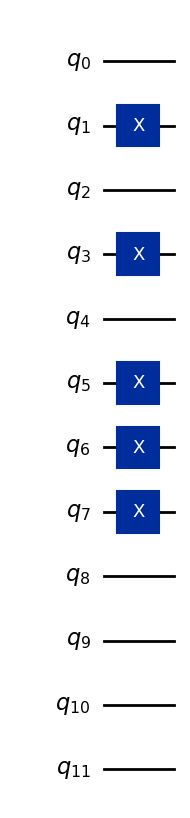

In [1]:
from qiskit import QuantumCircuit
 
# Data point to encode
x = 5  # binary: 0101
y = 7  # binary: 0111
z = 0  # binary: 0000
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,1]
y_bits = [int(b) for b in format(y, "04b")]  # [0,1,1,1]
z_bits = [int(b) for b in format(z, "04b")]  # [0,0,0,0]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,1,0,1,1,1,0,0,0,0]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

### 2. Amplitude Encoding
In amplitude encoding, each feature in a data vector is stored as an amplitude of a different quantum state. As an example, let's encode the first vector in our example dataset $\text{X}_\text{ex}$, $\vec{x}^{(1)} = (4,8,5)$ using amplitude encoding. Normalizing the resulting vector, we get:
$$
\sum_{i=1}^N \left|x^{(1)}_i\right|^2 = 4^2+8^2+5^2 = 105 = \left|\alpha\right|^2 \rightarrow \alpha = \sqrt{105}
$$
and the resulting 2-qubit quantum state would be:
$$
|\psi(\vec{x}^{(1)})\rangle = \frac{1}{\sqrt{105}}(4|00\rangle+8|01\rangle+5|10\rangle+0|11\rangle)
$$

In the example above, the number of features in the vector $N=3$, is not a power of 2. When $N$ is not a power of 2, we simply choose a value for the number of qubits $n$ such that $2^n\geq N$ and pad the amplitude vector with uninformative constants (here, a zero) so amplitude encoding of $N$ features requires $n \ge \mathrm{log}_2(N)$ qubits.

We can implement amplitude encoding easily in qiskit using initialize method as follows

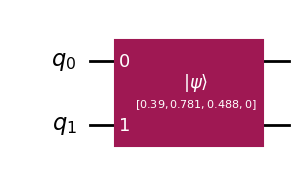

In [2]:
import math
 
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]
 
qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])
 
qc.draw(output="mpl")

### 3. Angle Encoding
In angle encoding:

*   Each feature value is mapped to a corresponding qubit, $\vec{x}^{(j)}_k \rightarrow Q_k$, leaving the qubits in a product state.
*   One numerical value is encoded at a time, rather than a whole set of features from a data point.
*   $n$ qubits are required for $N$ data features, where $n\leq N$. Often equality holds, here. We'll see how $n<N$ is possible in the next few sections.
*   The resulting circuit is a constant depth (typically the depth is 1 prior to transpilation).

The angle encoding can be implemented using any rotation gate. One additional feature of encoding our data using  Y-rotation is that it creates real-valued quantum states that can be useful for certain applications. The data has to be rescaled so that $\vec{x}^{(j)}_k \in (0,2\pi]$, preventing information loss and other unwanted effects.

The following Qiskit code rotates a single qubit from an initial state $|0\rangle$ to encode a data value $\vec{x}^{(j)}_k=\frac{1}{2}\pi$.

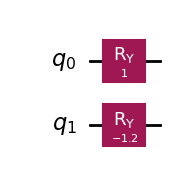

In [5]:
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(2)
state1 = Statevector.from_instruction(qc)
qc.ry(1, 0)  
qc.ry(-1.2, 1)  
qc.draw("mpl")

That was just a single feature of a single data vector. When encoding $N$ features into the rotation angles of $n$ qubits, say for the $j^\text{th}$ data vector $\vec{x}^{(j)} = (x_1,...,x_N),$ the encoded product state will look like this:
$$
|\vec{x}^{(j)}\rangle = \bigotimes^N_{k=1} R_Y(2\vec{x}^{(j)}_k)|0\rangle= \bigotimes^N_{k=1} \cos(\vec{x}^{(j)}_k)|0\rangle + \sin(\vec{x}^{(j)}_k)|1\rangle
$$

### 4. Phase Encoding
The phase encoding procedure maps each feature value to the phase $\phi$ of a corresponding qubit, $\vec{x}^{(j)}_k \rightarrow Q_k$. In total, phase encoding has a circuit depth of 2, including the Hadamard layer, which makes it an efficient encoding scheme. The phase-encoded multi-qubit state ($n$ qubits for $N=n$ features) is a product state:
$$
|\vec{x}^{(j)}\rangle = \bigotimes_{k=1}^{N} P_k(\phi = \vec{x}^{(j)}_k)|+\rangle^{\otimes N} = {\textstyle\frac{1}{\sqrt{2^N}}} \bigotimes_{k=1}^{N}\big(|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle\big).
$$

The following Qiskit code first prepares the initial state of a single qubit by rotating it with a Hadamard gate, then phase-ecodes the data point $\vec{x}^{(j)}_k=\frac{1}{2}\pi$ using a phase gate.


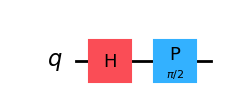

In [6]:
from qiskit.quantum_info import Statevector
from math import pi
qc = QuantumCircuit(1)
qc.h(0)  # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)

qc.p(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)

states = state1, state2

qc.draw("mpl", scale=1)

### 5. Dense angle encoding

Dense angle encoding (DAE) is a combination of angle encoding and phase encoding. DAE allows two feature values to be encoded in a single qubit: $\theta$ with a Y-axis rotation , and $\phi$ with a $z$-axis rotation. Encoding two data features to one qubit results in a $2$-times reduction in the number of qubits required for the encoding. Extending this to more features, the data vector $\vec{x} = (x_1,...,x_N)$ can be encoded as:

$$
|\vec{x}\rangle = \bigotimes_{k=1}^{N/2} \cos(\frac{x_{2k-1}}{2})|0\rangle + e^{i x_{2k}}\sin(\frac{x_{2k-1}}{2})|1\rangle
$$

DAE can be generalized to arbitrary functions of the two features instead of the sinusoidal functions used here. This is called general qubit encoding.

As an example of DAE, the code below encodes and visualizes the encoding of the features $x_1=\theta = 3\pi/8$ and $x_2=\phi = 7\pi/4$.

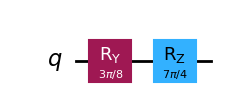

In [7]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3

qc.draw("mpl", scale=1)

### 6. Efficient SU2
Since amplitudes in a statevector are complex numbers, a single qubit state has four real parameters (though constrained by the requirement of normalization), a two qubit state has eight real parameters, and so on. The Efficient SU2 scheme can encode many more data points with fewer qubits. For example, a two qubit state with a single repetition is
$$
\begin{align}
\nonumber
|\psi\rangle_{\text{final}} &= \cos(\theta_0/2)
\left(\cos(\theta_4/2)|0\rangle+\sin(\theta_4/2)e^{i\theta_6}|1\rangle\right)\\ \nonumber
&\otimes \left[ \cos(\theta_1/2)
    \left( \cos(\theta_5/2)|0\rangle+\sin(\theta_5/2)e^{i \theta_7}|1\rangle\right)
+\sin(\theta_1/2)e^{i\theta_3}\left(-\sin(\theta_5/2)|0\rangle+\cos(\theta_5/2)e^{i \theta_7}|1\rangle\right)
    \right]\\ \nonumber
&+\sin(\theta_0/2)e^{i\theta_2}
\left(-\sin(\theta_4/2)|0\rangle+\cos(\theta_4/2)e^{i\theta_6}|1\rangle\right)\\ \nonumber
&\otimes \left[
\sin(\theta_1/2)e^{i\theta_3}\left(\cos(\theta_5/2)|0\rangle+\sin(\theta_5/2)e^{i \theta_7}|1\rangle\right)
+\cos(\theta_1/2)e^{i\theta_3}\left(-\sin(\theta_5/2)|0\rangle+\cos(\theta_5/2)e^{i \theta_7}|1\rangle\right)
\right]
\end{align}
$$

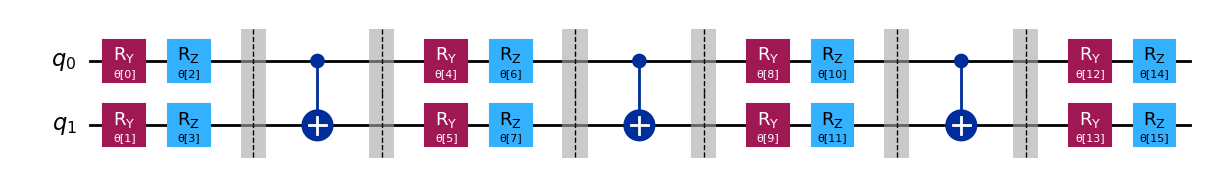

In [8]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=2, reps=3, insert_barriers=True)
circuit.draw(output="mpl")

However, we can encode more parameters with two qubits, though the state will not be unique any more

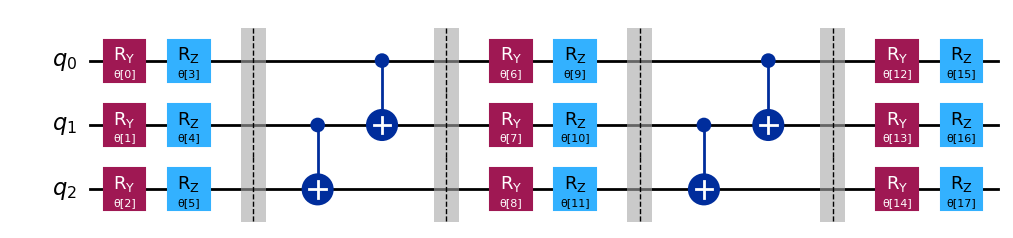

In [11]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=3, reps=2, insert_barriers=True)
circuit.draw(output="mpl")

we can assign parameters after creating the circuit

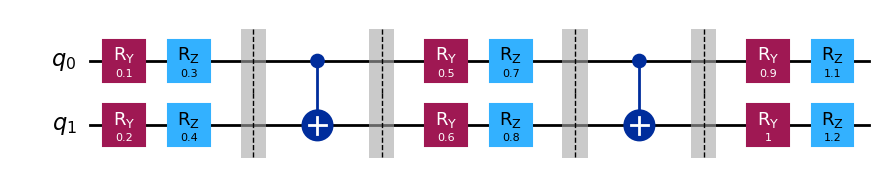

In [12]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=2, reps=2, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.draw(output="mpl")

another example with three qubits

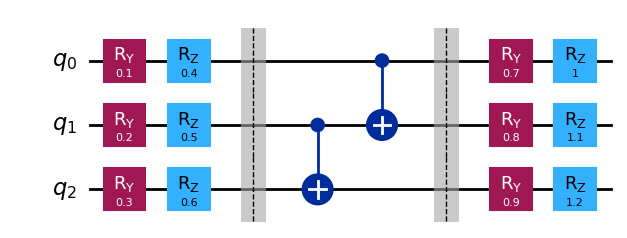

In [13]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
circuit = efficient_su2(num_qubits=3, reps=1, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.draw(output="mpl")

### 7. Z Feature Map
The $Z$ feature map (ZFM) can be interpreted as a natural extension of phase encoding. The ZFM consists of alternating layers  of Hadamard gates and and phase gates. Let the data vector $\vec{x}$ have $N$ features.  The data features $x_i$ are mapped one-to-one with corresponding qubits.  The full ZFM circuit unitary with a single repetition is:

$$
\mathscr{U}_{\text{ZFM}}=\big(P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)H^{\otimes N}\big)=\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}
$$

Then $r$ repetitions of this unitary would be

$$
\mathscr{U}^{(r)}_{\text{ZFM}}\left(\vec{x}\right)=\prod_{s=1}^{r}\left[\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}\right]
$$

The data features, $x_k$, are mapped to the phase gates in the same way in all $r$ repetitions. 

 The following Qiskit code uses Hadamard and phase gates explicitly to show the structure of the ZFM:

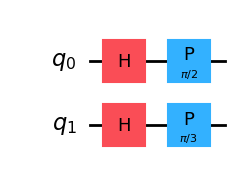

In [14]:
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)

qc0.h(0)
qc0.p(pi / 2, 0)

qc1.h(0)
qc1.p(pi / 3, 0)

# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)

qc.draw("mpl", scale=1)

### 8. ZZ Feature Map
The $ZZ$ feature map (ZZFM) extends the ZFM with the inclusion of two-qubit entangling gates, specifically the $ZZ$-rotation gate $R_{ZZ}(\theta)$. The ZZFM is conjectured to be generally expensive to compute on a classical computer, unlike the ZFM.

A single repetition of the ZZFM circuit is:

$$
\mathscr{U}_{\text{ZZFM}}(\vec{x}) = R_{ZZ,q,p}(\theta_{q,p})(\vec{x})\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N},
$$

 Entanglemt schemes can be linear, circular, full etc.  In the phase layer, the qubits p and q have phase gates that encode $\vec{x}_p$ and $\vec{x}_q$ on them, respectively. By default
$$
\theta_{q,p} \rightarrow \phi(\vec{x}_q, \vec{x}_p) = 2(\pi-\vec{x}_q)(\pi-\vec{x}_p).
$$
but we can define our own $\phi$ as well. Also, $R_{ZZ}$ can be replaced by another multi-qubit unitary.


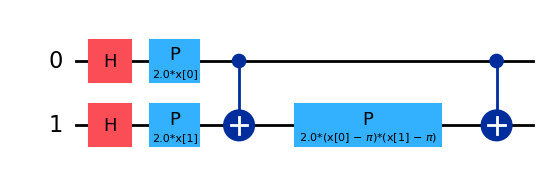

In [16]:
from qiskit.circuit.library import zz_feature_map

feature_dim = 2
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.draw("mpl", scale=1)

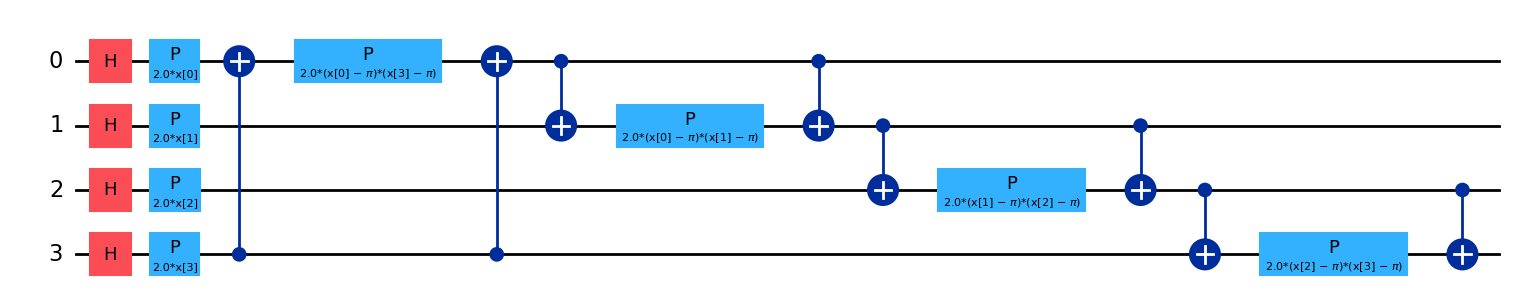

In [18]:
feature_dim = 4
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="circular", reps=1
)
zzfeature_map.draw("mpl", scale=1)

### 9. Pauli feature map

The Pauli feature map (PFM) is the generalization of the ZFM and ZZFM to use arbitrary Pauli gates. The Pauli feature map takes a very similar form to the previous two feature maps. For $r$ repetitions of the encoding of the $N$ features of vector $\vec{x},$

$$
\mathscr{U}_{\text{PFM}}(\vec{x}) = \prod_{s=1}^{r} U(\vec{x}) H^{\otimes n}.
$$

For PFM, $U(\vec{x})$ is generalized to a Pauli expansion unitary operator. Here we present a more generalized form of the feature maps considered so far:

$$
U(\bar{x}) = \exp\left(i \alpha \sum_{S\subseteq[n]} \phi_S(\bar{x}) \prod_{i \in S} \sigma_i \right)
$$

where $\sigma_i$ is a Pauli operator, $\sigma_i \in {I,X,Y,Z}$. Here $\mathcal{I}$ is the set of all qubit connectivities as determined by the feature map, including the set of qubits acted on by single-qubit gates. And

$$
\phi_S(\vec{x})=
    \begin{cases}
      x_i & \text{if } S= \{i\} \text{ (single-qubit)}\\
      \prod_{j\in{S}}(\pi-x_j) & \text{if } |S|\ge2 \text{ (multi-qubit)}\\
    \end{cases}
$$


The default value of $\alpha$ is $2$. By optimizing its value in the interval, for example, $[0,4],$ one can better align a quantum kernel to the data.

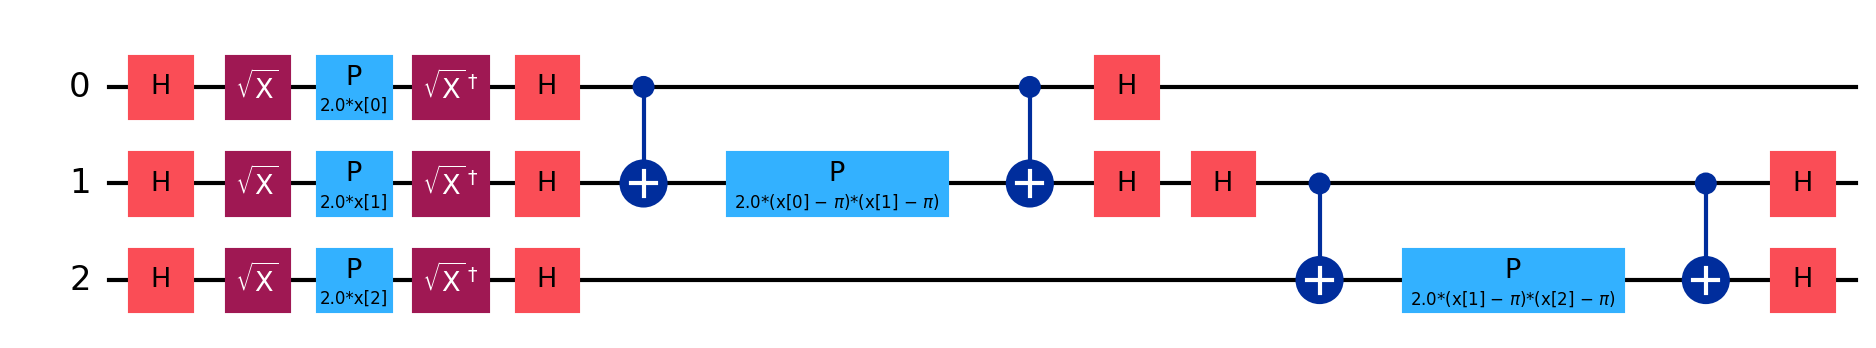

In [13]:
from qiskit.circuit.library import pauli_feature_map
 
feature_dim = 3
pfmap = pauli_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1, paulis=["Y", "XX"]
)
 
pfmap.draw("mpl", scale=1.5)

### 10. Two Local
It creates parameterized circuits of alternating rotation and entanglement layers. In both layers, parameterized circuit-blocks act on the circuit in a defined way. In the rotation layer, the blocks are applied stacked on top of each other, while in the entanglement layer according to the entanglement strategy. Each layer is repeated a number of times, and by default a final rotation layer is appended.


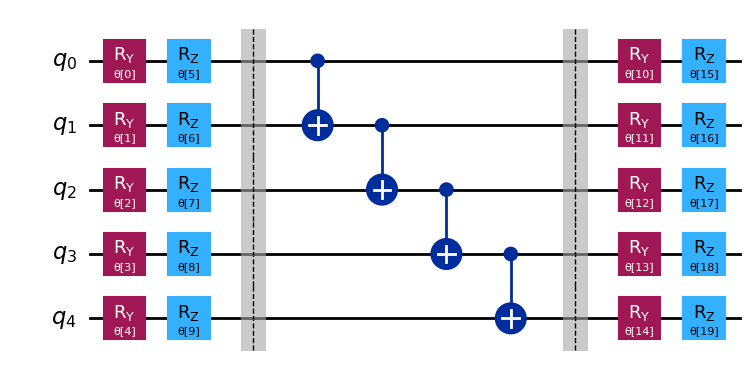

In [20]:
from qiskit.circuit.library import TwoLocal

twolocal = TwoLocal(num_qubits=5, reps=1, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='linear', insert_barriers=True)
twolocal.decompose().draw('mpl')

### 11. NLocal
In NLocal, the circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the circuit), while in TwoLocal, the rotation layers are single qubit gates applied on all qubits and the entanglement layer uses two-qubit gates.

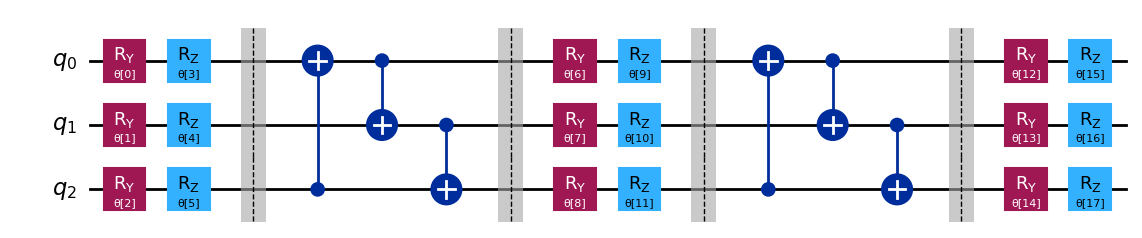

In [22]:
from qiskit.circuit.library import TwoLocal, NLocal, RYGate, RZGate, CXGate
from qiskit.circuit import Parameter
a=Parameter('a')
b=Parameter('b')
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(a), RZGate(b)], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

### 12. Custom encodings
We can prepare a variety of encoding schemese by combing the above methods. For example, we also encode parameters inside the rotation blocks as

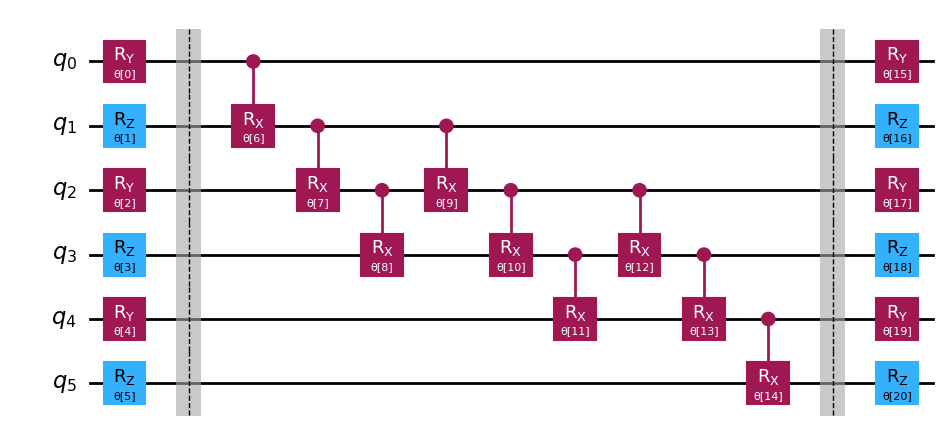

In [16]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import NLocal
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.decompose().draw('mpl')

The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)